---
## <b>1 <span style='color:#3f4d63'>I</span> Introduction</b>
---

This notebook corresponds to the 2nd part of the whole project I'm developing for this competition. **In 1st part I did a complete EDA of the data we're given. If you want to regard it, you'll find it here** -> [English language learning | Complete EDA](https://www.kaggle.com/code/javigallego/english-language-learning-complete-eda). 

If you want to just examine model's architecture, please head into [Model's Architecture]() subsection.

#### **Importing packages ⬇️**

In [ ]:
from IPython.display import clear_output, display_html
import gc; gc.enable()
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
import warnings
from pathlib import Path

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy import stats

# Train Test Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

warnings.filterwarnings('ignore')

def load_data():
    '''Load each of the datasets we are given.'''
    
    data_dir = Path("../input/feedback-prize-english-language-learning")
    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')
    return train, test, sample_submission

train, test, sample_submission = load_data()
clear_output()

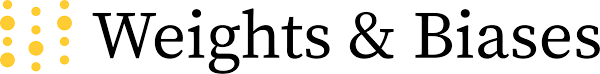

### **Weights and Biases ⬇️**

You will need a unique API key to log in to Weights & Biases.

* If you don't have a Weights & Biases account, you can go to [https://wandb.ai/site](https://wandb.ai/site) and create a FREE account. Access your API key: [https://wandb.ai/authorize](https://wandb.ai/authorize).

There are two ways you can login using a Kaggle kernel:

* Run a cell with `wandb.login()`. It will ask for the API key, which you can `copy` + `paste` in.
* You can also use Kaggle secrets to store your API key and use the code snippet below to login. Check out [this discussion post](https://www.kaggle.com/product-feedback/114053) to learn more about Kaggle secrets.

In [ ]:
!pip install wandb
clear_output()
import wandb
from wandb.keras import WandbCallback

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

---
## <b>2 <span style='color:#3f4d63'>I</span> Data Preprocessing</b>
---

In [ ]:
import re
from nltk.tokenize import sent_tokenize
from textblob import TextBlob

train['full_text'] = train["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
test['full_text'] = test["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
train['ncharacters'] = train['full_text'].str.len()
train['ncharacters'] = train['full_text'].str.len()
train['sent_count'] = train['full_text'].apply(lambda x: len(sent_tokenize(x)))
train['avg_sent_len'] = train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
train['polarity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[0])
train['subjetivity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[1])

In [ ]:
import string

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)    
    return text

---
## <b>3 <span style='color:#3f4d63'>I</span> Modeling</b>
---

> **MUST read** -> [The art of pooling embeddings](https://blog.ml6.eu/the-art-of-pooling-embeddings-c56575114cf8)

In this section we're gonna use mainly **Deberta Transformer Model**. Its working procedure it's easy: 

* We feed the input sentence or text into a transformer network (like Bert, Deberta, etc). 
* The transformer produces contextualized word embeddings for all input tokens in our text.

As we want a fixed-sized output representation (vector u), we need a pooling layer. **Thus, in first subsections you'll find explanations for several type of poolings.** 

![](https://www.sbert.net/_images/SBERT_Architecture.png)

In [ ]:
from transformers import DebertaTokenizer, TFDebertaModel

tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
tokenizer.save_pretrained('./tokenizer/')
model = TFDebertaModel.from_pretrained("microsoft/deberta-base")
clear_output()

## Model Inputs Explained

Every model is different yet bears similarities with the others. Therefore most models use the same inputs, which are detailed here alongside usage examples. Let's explain a little bit what `tokenizer` is gonna return. **The tokenizer takes care of splitting the sequence into tokens available in the tokenizer vocabulary.**

* Quick example:

In [ ]:
sequence = "A Titan RTX has 24GB of VRAM"
tokenized_sequence = tokenizer.tokenize(sequence)
print(tokenized_sequence)

del sequence, tokenized_sequence
gc.collect();

The tokens are either words or subwords. However, they must be **converted into IDs**, which are understandable by the model. 

> In this following [link](https://huggingface.co/docs/transformers/v4.22.1/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.batch_encode_plus) you'll find information about `batch_encode_plus` and its parameters.

In [ ]:
# Inspired by: https://www.kaggle.com/code/junjitakeshima/ell-simple-roberta-starter-eng
def create_data(text, tokenizer):
    '''Tokenizes the training data. It only returns IDs and attention masks.'''
    
    encoded = tokenizer.batch_encode_plus(text, add_special_tokens = True, max_length= 128,
              padding='max_length', truncation=True, return_attention_mask=True)

    input_ids       = np.array(encoded["input_ids"], dtype="int32")
    attention_mask = np.array(encoded["attention_mask"], dtype="int32")

    return {"input_ids": input_ids, "attention_mask": attention_mask}

model_inputs = create_data(train['full_text'], tokenizer)
test_data = create_data(test['full_text'], tokenizer)
model_inputs

**Explanation**:

* **Input IDs**: they are often the **only required parameters** to be passed to the **model** as **input**. They are **token indices**, numerical representations of tokens building the sequences that will be used as input by the model. For more detailed information watch [this video](https://youtu.be/VFp38yj8h3A).

* **Attention Mask**: this argument indicates to the model which tokens should be attended to, and which should not. For example, consider these two sequences:

In [ ]:
sequence_a = "This is a short sequence."
sequence_b = "This is a rather long sequence. It is at least longer than the sequence A."

encoded_sequence_a = tokenizer(sequence_a)["input_ids"]
encoded_sequence_b = tokenizer(sequence_b)["input_ids"]

The encoded versions have different lengths:

In [ ]:
print(len(encoded_sequence_a), len(encoded_sequence_b))

del sequence_a, sequence_b, encoded_sequence_a, encoded_sequence_b
gc.collect();

Therefore, we can’t put them together in the same tensor as-is. The first sequence needs to be padded up to the length of the second one, or the second one needs to be truncated down to the length of the first one.

In the first case, the list of IDs will be extended by the padding indices. This is the moment where the attention mask comes into play. **The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.**

## **Model Outputs Explained**

This section is mainly inspired in these amazing works: [Utilizing Transformer Representations Efficiently](https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently), and [Illustrated Bert](http://jalammar.github.io/illustrated-bert/). Its aim is to explain commonly transformer's outputs. This will help to understand next sections, dedicated to pooling embeddings. 

In [ ]:
# Code taken from: https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently

import torch
import torch.nn as nn
import transformers
from transformers import (
    AutoModel, AutoConfig, 
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['full_text'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model2 = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer2 = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer2.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model2(features['input_ids'], features['attention_mask'])
outputs

**Explanations**

* `last_hidden_state`: this is the first and default output from models. It's a sequence of hidden-states at the output of the last layer of the model. The `last_hidden_state` is **passed into the pooler** and this returns the `pooler_output`. We can deactivate pooler outputs by setting add pooling layer to False in model config and passing that to model.

* `pooler_output`: last layer hidden-state of the first token of the sequence (classification token) after further processing by a Linear layer and a Tanh activation function.

* `hidden_states`: hidden-states of the model at the output of each layer plus the optional initial embedding outputs.

* `attentions`

![](https://media.geeksforgeeks.org/wp-content/uploads/20200420231335/elmo-eemmbeddings.jpg)

## **CLS Embeddings**

[CLS] token appears at the very beginning of each sentence, it has a fixed embedding and a fix positional embedding, thus this token contains no information itself. However, **the output of [CLS] is inferred by all other words in this sentence**, so [CLS] token would have captured the entire context. This makes [CLS] a good representation for sentence-level classification.

![](https://help-static-aliyun-doc.aliyuncs.com/assets/img/en-US/4024896061/p162090.png)

* **Implementation**: 

In [ ]:
last_hidden_state = outputs[0]
cls_embeddings = last_hidden_state[:, 0]
#logits = nn.Linear(config.hidden_size, 1)(cls_embeddings) # regression head

## **Types of Pooling**

### **Mean Pooling**

There are different ways of procceding. We can simply average all contextualized word embeddings BERT is giving us. However, we'll make it a bit more complicated. We will make use of attention masks as well so that we can ignore padding tokens which is a better way of implementing average embeddings.

* **Step 1**: Expand Attention Mask from [batch_size, max_len] to [batch_size, max_len, hidden_size].
* **Step 2**: Sum Embeddings along max_len axis so now we have [batch_size, hidden_size].
* **Step 3**: Sum Mask along max_len axis. This is done so that we can ignore padding tokens.
* **Step 4**: Take Average.

In [ ]:
attention_mask = features['attention_mask']
input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
sum_mask = input_mask_expanded.sum(1)
sum_mask = torch.clamp(sum_mask, min=1e-9)
mean_embeddings = sum_embeddings / sum_mask
#logits = nn.Linear(config.hidden_size, 1)(mean_embeddings) # regression head

### **Max Pooling**

This is quite similar to the previous type. The difference between them is, as its name reflects, that rather than performing the mean operation, we perform the maximum one. 

In [ ]:
input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
last_hidden_state[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
max_embeddings = torch.max(last_hidden_state, 1)[0]

There are more types of pooling, but for not making this notebook so tedious I'm just gonna finish here. If you are interested, [here](https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently) you'll find more types.

In [ ]:
del train_text, tokenizer2, model2, config
gc.collect();

## Model's Architecture (no finetuning)

Regarding previous versions' performance we conclude that we must speed up training and inference process. We can't spent such a big amount of time training **ONLY ONE TRANSFORMER-BASED MODEL**. Imagine what will happen if we try to make an ensembling !

Therefore, we need to change the approach a bit. In this subsection we're gonna focus on extracting embedding from **non-finetuned** Transformers (Deberta base, Deberta Large, Funnel Transformer, Bigbird, etc). With this, we'll save a huge amount of time. Lastly, having all this done we'll add a multioutpt regressor as the head of our model, and feed it with an ensembling of all those embedding we extracted before. 

* One **advantage** that this approach has is that as well as embeddings, we can feed the regressor with features like (sentence count, polarity, subjetivity). In other words, we can make some **feature engineering**. 

In [ ]:
from IPython.display import clear_output, display_html
import gc; gc.enable()
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
import warnings
from pathlib import Path

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy import stats

# Train Test Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Optuna - Bayesian Optimization 
import optuna
from optuna.samplers import TPESampler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# PyTorch
import torch
import torch.nn as nn

# Transformers
import transformers
from transformers import AutoModel, AutoConfig, AutoTokenizer

# Regressors
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tqdm import tqdm

warnings.filterwarnings('ignore')
MAX_SEQ_LEN = 256

def load_data():
    '''Load each of the datasets we are given.'''
    
    data_dir = Path("../input/feedback-prize-english-language-learning")
    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')
    return train, test, sample_submission

def mcrmse(y_true, y_pred):
    '''Returns value for MCRMSE (competition's metric)'''
    
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

train, test, sample_submission = load_data()
clear_output()

In [ ]:
import re
import string

#Aquí hay un problema, al borrar las comas si no hay espacio con la palabra siguiente
#se nos juntan las palabras !!!
# Ejemplo: casa,perro,gato

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)    
    return text

In [ ]:
train['full_text'] = train['full_text'].map(lambda x: clean_text(x))
train['full_text'] = train["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

test['full_text'] = test['full_text'].map(lambda x: clean_text(x))
test['full_text'] = test["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

As we know, each token from the text will have an embedding. However, we want just **one embedding per essay**. In order to get it, we need perform a **pooling operation**. There are a wide variety of types. Hereafter, you'll find some of them implemented. 

In [ ]:
def CLS_embeddings(output):
    '''Returns the embeddings corresponding to the <CLS> token of each text. '''

    last_hidden_state = output[0]
    cls_embeddings = last_hidden_state[:, 0]
    return cls_embeddings

def MeanPooling(output, attention_mask): 
    '''Performs the mean pooling operation. '''
    
    last_hidden_state = output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    mean_embeddings = sum_embeddings / sum_mask
    return mean_embeddings

def MaxPooling(output, attention_mask):
    '''Performs the max pooling operation. '''
        
    last_hidden_state = output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    last_hidden_state[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    max_embeddings = torch.max(last_hidden_state, 1)[0]
    return max_embeddings

* Due to kernel's memory limit, we'll need to split our data to get the embeddings. To do so, we'll make use of `DataLoader` from torch utils. We're gonna a `batch_size` of 4.

> Try to tokenize the whole dataset texts at once. You'll find that when trying to get the embeddings from the model the notebook will run out of memory. Due to that we proceed as told above. 

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train.full_text.tolist(),\
                        batch_size=4,\
                        shuffle=False)

test_data_loader = torch.utils.data.DataLoader(test.full_text.tolist(),\
                        batch_size=4,\
                        shuffle=False)

Finally, let's define the functions to get our text's embeddings. 

In [ ]:
def get_embeddings_from(data, tokenizer, model, pooler):
    '''Returns an embedding list for a concrete data. '''
    
    final_embeddings = []    
    for batch in tqdm(data, total = len(data)):
        model_inputs = tokenizer.batch_encode_plus(
            batch,
            add_special_tokens=True,
            padding='max_length',
            max_length=MAX_SEQ_LEN,
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )

        #input_ids = model_inputs['input_ids']
        #attention_mask = model_inputs['attention_mask']
        input_ids = model_inputs['input_ids'].to("cuda")
        attention_mask = model_inputs['attention_mask'].to("cuda")
        with torch.no_grad():
              outputs = model(input_ids, attention_mask)

        # We want one embedding per text. Thus, we need to perform a pooling operation
        if pooler == 'max':
            embeddings = MaxPooling(outputs, attention_mask)
        elif pooler == 'mean':
            embeddings = MeanPooling(outputs, attention_mask)
        else:
            embeddings = CLS_embeddings(outputs)
            
        embeddings = embeddings.cpu().detach().numpy()
        final_embeddings.extend(embeddings)
        
    return final_embeddings

def extract_embeddings(_pretrained_model, pooler):
    '''Downloads model and tokenizer from _pretrained_model. 
       It returns embeddings for each training and testing data.'''
    
    #config = AutoConfig.from_pretrained(_pretrained_model)
    model = AutoModel.from_pretrained(_pretrained_model)
    tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

    # We are gonna sent everything to GPU, to make the extraction even faster
    model = model.to("cuda")
    train_embeddings = get_embeddings_from(train_data_loader, tokenizer, model, pooler)
    test_embeddings = get_embeddings_from(test_data_loader, tokenizer, model, pooler)
        
    return train_embeddings, test_embeddings

Transformers that we're going to use to get the embeddings: 

* DeBERTa Large
* DeBERTa v3 Base
* DeBERTa v3 Large
* Big Bird (RoBERTa based)
* Funnel Transformer

In [ ]:
for pooler in ['max','mean','cls']:
    deberta_large_train_embeddings, deberta_large_test_embeddings = extract_embeddings('../input/huggingface-deberta-variants/deberta-large/deberta-large', pooler)
    debertav3_train_embeddings, debertav3_test_embeddings = extract_embeddings('../input/huggingface-deberta-variants/deberta-base/deberta-base', pooler)
    debertav3_large_train_embeddings, debertav3_large_test_embeddings = extract_embeddings('../input/deberta-v3-large/deberta-v3-large', pooler)
    bigbird_train_embeddings, bigbird_test_embeddings = extract_embeddings('../input/huggingfacebigbirdrobertabase', pooler)
    funnel_train_embeddings, funnel_test_embeddings = extract_embeddings('../input/funneltransformerlarge', pooler)
    
    transformers_train_embeddings = [deberta_large_train_embeddings, debertav3_train_embeddings,
            debertav3_large_train_embeddings, bigbird_train_embeddings, funnel_train_embeddings]

    transformers_test_embeddings = [deberta_large_test_embeddings, debertav3_test_embeddings,
                debertav3_large_test_embeddings, bigbird_test_embeddings, funnel_test_embeddings]

    if pooler == 'max':
        train_embeddings_np = np.concatenate(transformers_train_embeddings, axis = 1)
        test_embeddings_np = np.concatenate(transformers_test_embeddings, axis = 1)
        train_embeddings = pd.DataFrame(train_embeddings_np)
        test_embeddings = pd.DataFrame(test_embeddings_np)
        
    else: 
        train_embeddings = pd.concat([train_embeddings, pd.Series(np.concatenate(transformers_train_embeddings, axis = 1))], axis = 1)
        test_embeddings = pd.concat([test_embeddings, pd.Series(np.concatenate(transformers_test_embeddings, axis = 1))], axis = 1)

    # In order to save some memory let's delete each transformer's embeddings
    for dt in [transformers_train_embeddings, transformers_test_embeddings]:
        for emb in dt: 
            del emb

Once we have extracted all the embeddings we wanted, it's time to concat them into one huge embedding. Apart from that, we can get rid of each transformer embeddings. By doing this we'll save some useful memory.  

### **PCA**

The embeddings dataframes that we have extracted are ridiculously large. However, we can perform some dimensionality reduction to fix it. We'll proceed with Principal Component Analysis technique: 

> Please note that, although here you'll not find anything about that here, pre-requisites (for a proper PCA application) such as correlation between features, normalized data, etc have been checked already. 

In [ ]:
#train_embeddings = pd.DataFrame(train_embeddings_np)
#test_embeddings = pd.DataFrame(test_embeddings_np)

In [ ]:
from sklearn.preprocessing import *
from sklearn.decomposition import PCA

def apply_pca(X, transformer = False, components = -1):
    aux = X.copy()
    if transformer:
        X = pd.DataFrame(transformer.fit_transform(X))
        X.columns = aux.columns    
    # Create principal components
    if components == -1:
        pca = PCA()
    else:
        pca = PCA(n_components = components)
        
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2, sharey = True)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance")    # ylim = (0.0, 1.0) o sino sharey en plt.subplots
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance"
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [ ]:
X_para_pca = train_embeddings
sc = StandardScaler()
X_para_pca = pd.DataFrame(sc.fit_transform(X_para_pca))
pca, X_pca, loadings = apply_pca(X_para_pca)
plt.figure(figsize = (22,5))
ax0, ax1 = plot_variance(pca)
ax1.set_xlim(-50,2000)
ax1.axhline(y = 0.9, color = 'r', linestyle = '-') 

Looking at the previous chart we can't guess clearly which is the optimal number of components to choose. There are some techniques to discover it. In this case, the rule of Abdi et al. (2010) is used. **The variances explained by the principal components are averaged and we select those whose proportion of explained variance exceeds the mean.** 

In [ ]:
#np.mean(pca.explained_variance_ratio_, axis = 1)
media = np.mean(pca.explained_variance_ratio_)
componentes = []
for i in range(X_pca.shape[1]):
    if pca.explained_variance_ratio_[i] > media: 
        componentes.append(i)

In [ ]:
component = 'PC{}'.format(len(componentes))
train_embeddings = X_pca.loc[:,:component]
test_embeddings = sc.transform(test_embeddings)
test_embeddings = pca.transform(test_embeddings)
test_embeddings = pd.DataFrame(test_embeddings, columns = ['PC{}'.format(i) for i in range(1,X_pca.shape[1]+1)]).loc[:,:component]

### **Applying Regressors**

From now onwards, there's a big variety of possible configurations. Starting from the regressors to use, to feature engineering, the different kind of cross validation techniques to apply, the ensembling part, etc. It's a personal choice. 

* In this version you'll find some hyperparameter tuning done with Optuna, for both XGBoost and LightGBM.  

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
def objective(trial):
    # Parámetros XGBoost
    params = {"random_state":trial.suggest_categorical("random_state", [2022]),           # categorical for concrete values
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),   # loguniform for continuos values
        "n_estimators": trial.suggest_int('n_estimators',50,2000),                 # int for discrete values. Interval between [100,2000]
        "max_depth" : trial.suggest_int("max_depth", 1, 20),
        "alpha" : trial.suggest_loguniform('alpha',0.9,1),
        "tree_method": trial.suggest_categorical("tree_method", ['gpu_hist']), 
        "predictor": trial.suggest_categorical("predictor", ["gpu_predictor"])
    }

    model = XGBRegressor(**params)
    X_train_tmp, X_valid_tmp, y_train_tmp, y_valid_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(
        X_train_tmp, y_train_tmp,
        eval_set=[(X_valid_tmp, y_valid_tmp)],
        early_stopping_rounds=35, verbose=0
    )
        
    y_train_pred = model.predict(X_train_tmp)
    y_valid_pred = model.predict(X_valid_tmp)
    train_mae = mae(y_train_tmp, y_train_pred)
    valid_mae = mae(y_valid_tmp, y_valid_pred)
    
    print(f'MCRMSE of Train: {train_mae}')
    print(f'MCRMSE of Validation: {valid_mae}')
    
    return valid_mae

def optuna_xgb(trials = 100, timeout = 1200):
    TRIALS = trials
    TIMEOUT = timeout
    
    sampler = TPESampler(seed=42)

    study = optuna.create_study(
        study_name = 'XGB_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=TRIALS)
    print("Best Score:",study.best_value)
    print("Best trial",study.best_trial.params)
    
    best_params = study.best_params
    return best_params

def objective_lgbm(trial):
    # Parámetros LightGBM
    params = {"random_state":trial.suggest_categorical("random_state", [2022]),           
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),   
        "n_estimators": trial.suggest_int('n_estimators',50,2000),                 
        "max_depth" : trial.suggest_int("max_depth", 1, 20),
        "_min_child_weight" : trial.suggest_float("_min_child_weight", 0.1, 10),
        "reg_lambda" : trial.suggest_float("reg_lambda", 0.01, 10),
        "reg_alpha" : trial.suggest_float('reg_alpha',0.01,10),
        "num_leaves" : trial.suggest_int("num_leaves", 50, 100),
        'subsample' : trial.suggest_float('subsample', 0.01, 1), 
        'device': trial.suggest_categorical("device", ['gpu'])
    }

    model = LGBMRegressor(**params)
    X_train_tmp, X_valid_tmp, y_train_tmp, y_valid_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(
        X_train_tmp, y_train_tmp,
        eval_set=[(X_valid_tmp, y_valid_tmp)],
        early_stopping_rounds=35, verbose=0
    )
        
    y_train_pred = model.predict(X_train_tmp)
    y_valid_pred = model.predict(X_valid_tmp)
    train_mae = mae(y_train_tmp, y_train_pred)
    valid_mae = mae(y_valid_tmp, y_valid_pred)
    
    print(f'MCRMSE of Train: {train_mae}')
    print(f'MCRMSE of Validation: {valid_mae}')
    
    return valid_mae

def optuna_lgbm(trials = 100, timeout = 1200):
    TRIALS = trials
    TIMEOUT = timeout
    
    sampler = TPESampler(seed=42)

    study = optuna.create_study(
        study_name = 'LGBM_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective_lgbm, n_trials=TRIALS)
    print("Best Score:",study.best_value)
    print("Best trial",study.best_trial.params)
    
    best_params = study.best_params
    return best_params

In [ ]:
%%time
X = train_embeddings
scores = train.select_dtypes([int, float]).columns[:6]
def model_preds(regressor, optuna_tuning):
    '''Returns predictions made by a concrete regressor. '''
    global y
    preds = {}
    for j, col in enumerate(scores): 
        y = train[col]
        best_params = optuna_tuning()
        regressor_tuned = regressor(**best_params)
        
        regressor_tuned.fit(train_embeddings, train[col])  
        preds[j] = regressor_tuned.predict(test_embeddings)

    return preds

xgb_preds = model_preds(XGBRegressor, optuna_xgb)
lgbm_preds = model_preds(LGBMRegressor, optuna_lgbm)
clear_output()

In [ ]:
preds = {}
for i in range(6):
    preds[i] = (xgb_preds[i] + lgbm_preds[i]) / 2

**To be continued ...**